# Distribution of top incomes /  Top Incomes Share in Different Countries

**Author:** [Ramiro Gómez](http://ramiro.org/)

The [World Top Incomes Database](http://topincomes.g-mond.parisschoolofeconomics.eu/) originated from research by Thomas Piketty on the distribution of top incomes in France in 2001 and has since then gathered information for more than 20 countries generating a large volume of data, intended as a resource for further analysis and research. The database is compiled and maintained by Facundo Alvaredo, Tony Atkinson, Thomas Piketty and Emmanuel Saez.

The income data being explored in this notebook was downloaded on July 25, 2016. 

In [32]:
%matplotlib inline

import itertools
import math

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('ramiro')

df = pd.read_excel('csv/top-incomes.xlsx', 1, skiprows=1)

chartinfo = 'Author: Ramiro Gómez - ramiro.org • Data: World Top Incomes Database - parisschoolofeconomics.eu'

## Exploring the dataset

In [2]:
df.head()

,Country,Year,Top 10% income share,Top 10% income share-LAD,Top 10% income share-married couples & single adults,Top 10% income share-adults,Top 10% income share-tax data,Top 10% income share-IDS,Top 5% income share,Top 5% income share-LAD,...,Top 0.5-0.1% average income-including capital gains,Top 0.1-0.01% average income-including capital gains,P90 income threshold-including capital gains,P95 income threshold-including capital gains,P99 income threshold-including capital gains,P99.5 income threshold-including capital gains,P99.9 income threshold-including capital gains,P99.99 income threshold-including capital gains,Pareto-Lorenz coefficient,Inverted Pareto-Lorenz coefficient
0,Argentina,1932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.659,2.517
1,Argentina,1933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.674,2.484
2,Argentina,1934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.652,2.534
3,Argentina,1935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.655,2.526
4,Argentina,1936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.723,2.382


The table has one record per year and country for more than 400 different variables. Coverage for each country and year varies in the top incomes database. To be able to compare countries in a single year or across a range of years, we have to make sure, that there is sufficient data available.

First let's find out the most recent year that has at least 10 records in the `Top 1% income share` column. We set column variables, create a new dataframe with the relevant columns, call the `value_counts()` method of the `Year` series, then select only the years with more then 10 records, and sort the result in descending order by year.

In [3]:
income_col = 'Top 1% income share'
cols = ['Year', 'Country', income_col]
df_top = df[cols].dropna(axis=0, how='any')

year_counts = df_top.Year.value_counts()
sufficient = year_counts[year_counts > 10]
sufficient.sort_index(ascending=False).head()

2011    12
2010    16
2009    17
2008    17
2007    17
dtype: int64

## Income share of top 1% earners across countries in 2010

Since 2010 is the most recent year with enough records, it will be used for plotting a country ranking sorted by the income share of the top 1% earners from higher to lower percentages.

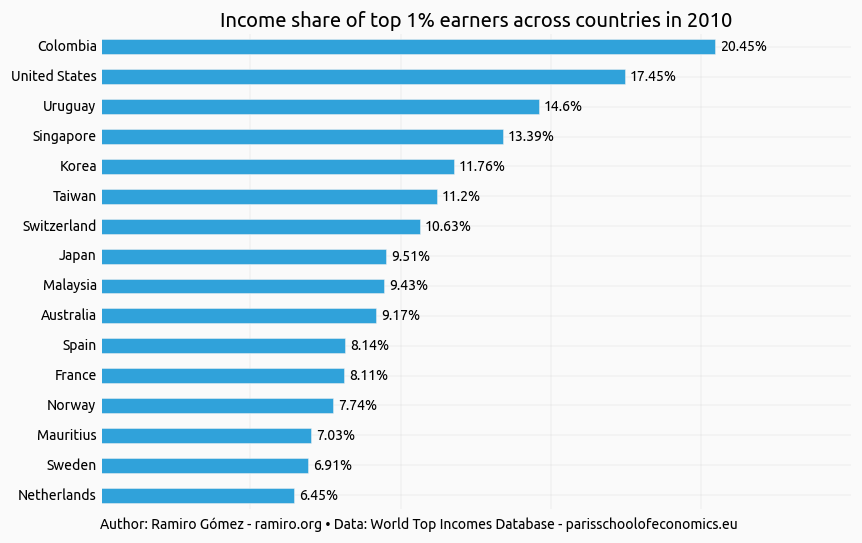

In [4]:
year = 2010
title = 'Income share of top 1% earners across countries in {}'.format(year)

df_top_year = df_top[df_top['Year'] == year].sort(columns=[income_col])

s = df_top_year.set_index('Country')[income_col]
ax = s.plot(
    kind='barh',
    figsize=(12, 8), 
    title=title)
ax.tick_params(labelbottom='off')
ax.set_ylabel('', visible=False)

for i, label in enumerate(s):
    ax.annotate(str(label) + '%', (label + .2, i - .15))

plt.annotate(chartinfo, xy=(0, -1.04), xycoords='axes fraction')
plt.savefig('img/income-share-top1-{}.png'.format(year), bbox_inches='tight')

## Evolution of 'Top 1% Income Share' of Selected Countries

Show the evolution of the top 1% income share for several countries with fairly comprehensive data for the period from 1912 to 2012.

In [5]:
df_pivot = df_top.pivot(*cols)

num_countries = len(df_pivot.columns)
xmax = max(df_pivot.index)
xmin = xmax - 100

ncols = 5
nrows = math.ceil(num_countries / ncols)

title = 'Income share of top 1% earners in {:d} countries between {:d} and {:d}'.format(num_countries, xmin, xmax)
footer = 'Included are countries with at least one record for the top 1% income share in the given time range.\n' + chartinfo

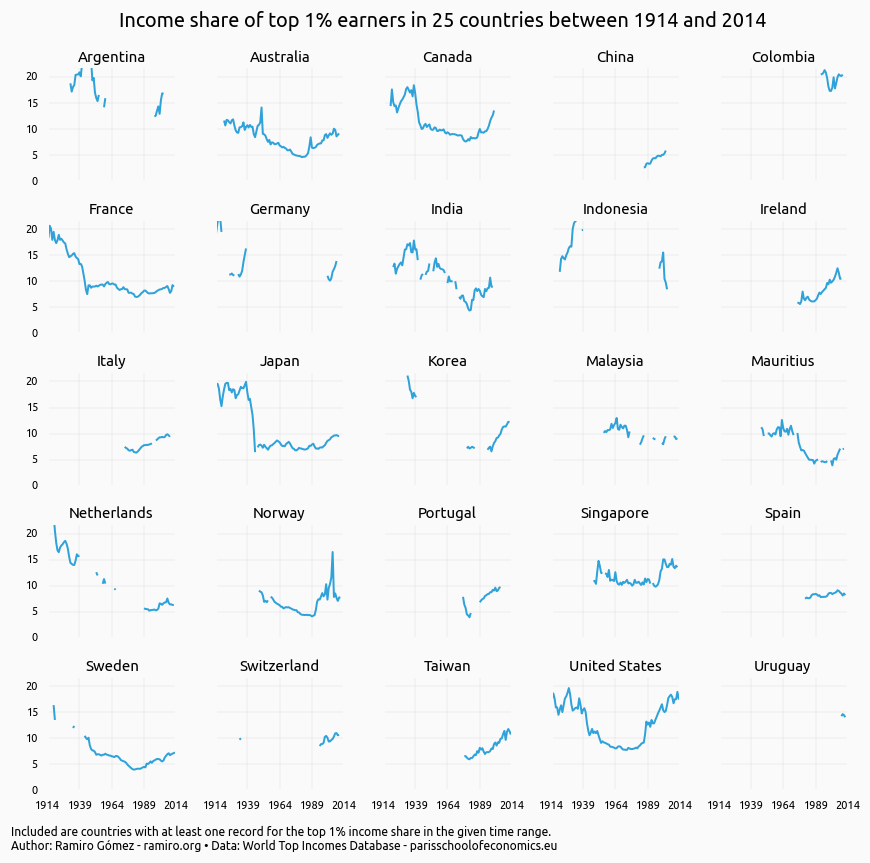

In [6]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
fig.suptitle(title, y=1.03, fontsize=20)
fig.set_figwidth(12)
fig.set_figheight(11)

for idx, coords in enumerate(itertools.product(range(nrows), range(ncols))):
    ax = axes[coords[0], coords[1]]
    country = df_pivot.columns[idx]
    df_pivot[country].plot(
        ax=ax, 
        legend=False, 
        linewidth=2, 
        ylim=(0, 22), xlim=(xmin, xmax)
    )
    
    ax.set_title(country, fontsize=15)
    ax.set_xlabel('', visible=False)
    ax.set_xticks(list(range(xmin, xmax + 1, 25)))
    ax.tick_params(pad=10, labelsize=11)


fig.text(0, -.03, footer, fontsize=12)
fig.tight_layout()

plt.savefig('img/evolution-top-1-percent-income-share.png', bbox_inches='tight')

We can see that in the displayed period France, Japan and the United States have the best data coverage for this indicator.

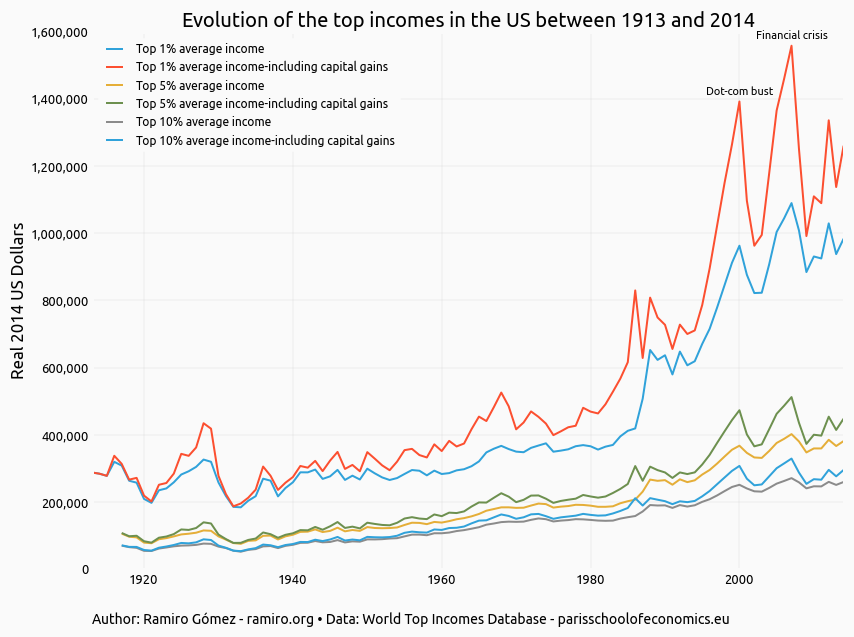

In [100]:
cols = [
    'Top 1% average income', 
    'Top 1% average income-including capital gains', 
    'Top 5% average income', 
    'Top 5% average income-including capital gains',
    'Top 10% average income', 
    'Top 10% average income-including capital gains'
]
highlight = 'Top 1% average income-including capital gains'

df_us = df[df['Country'] == 'United States']
df_us.set_index('Year', inplace=True)

title = 'Evolution of the top incomes in the US between {} and {}'.format(df_us.index.min(), df_us.index.max())

ax = df_us[cols].plot(figsize=(12, 9), title=title, fontsize=13)

ax.yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda val, p: format(int(val), ',')))

ax.set_ylabel('Real 2014 US Dollars')
ax.set_xlabel('', visible=False)
ax.legend(loc=2, prop={'size': 12})
plt.annotate(chartinfo, xy=(0, -1.1), xycoords='axes fraction')

plt.annotate(
    'Dot-com bust', 
    xy=(2000, df_us.ix[2000][highlight]),
    xytext=(0, 5),
    textcoords='offset points',
    ha='center',
    va='bottom',
    size=11)

plt.annotate(
    'Financial crisis', 
    xy=(2007, df_us.ix[2007][highlight]),
    xytext=(0, 5),
    textcoords='offset points',
    ha='center',
    va='bottom',
    size=11)

The average income of top 1% earners clearly increased the most over the hundred year period most dramatically beginning in the mid 1980s. In the past 30 years we see the most extreme fluctuations, for example the steep increase and decline around the dot-com bust in 2000 and the financial crisis of 2007-08.